# Sentiment Analysis using Hierarchical Attention Networks
## Introduction
A basic task in sentiment analysis is classifying the polarity of a given text at the document, sentence, or feature/aspect level—whether the expressed opinion in a document, a sentence or an entity feature/aspect is positive, negative, or neutral.

Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

Sentiment Analysis is a common NLP task that Data Scientists need to perform. **This is a guide to creating a movie review classifier in Keras using Hierarchical Attention Networks.**

## Importing Libraries

In [0]:
import os
import sys
import re
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,auc,confusion_matrix
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, GRU, Bidirectional, TimeDistributed 
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from nltk import tokenize
import matplotlib.pyplot as plt
iteration1 = True

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Overview
For the purpose of this analysis we’ll be using a dataset of 50,000 movie reviews taken from IMDb. 
The data was compiled by Andrew Maas and can be found here: https://ai.stanford.edu/~amaas/data/sentiment/

The data is split evenly with 25k reviews intended for training and 25k for testing your classifier. Moreover, each set has 12.5k positive and 12.5k negative reviews.

IMDb lets users rate movies on a scale from 1 to 10. To label these reviews the curator of the data labeled anything with ≤ 4 stars as negative and anything with ≥ 7 stars as positive. Reviews with 5 or 6 stars were left out.

In [0]:
def load_dataset(path):
    
    train_texts,train_labels = [],[]
    test_texts,test_labels = [],[]
    
    for dataset in ['train', 'test']:
        for category in ['pos', 'neg']:
            dataset_path = os.path.join(path, dataset, category)
            for filename in sorted(os.listdir(dataset_path)):
                if filename.endswith('.txt'):
                    with open(os.path.join(dataset_path, filename), encoding="utf8") as f:

                        label = 1 if category == 'pos' else 0
                        if dataset == 'train': 
                            train_texts.append(f.read())
                            train_labels.append(label)
                        else: 
                            test_texts.append(f.read())
                            test_labels.append(label)

    # Converting to np.array
    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    # Shuffle the training data
    permutation = np.random.permutation(len(train_texts))
    train_texts, train_labels = train_texts[permutation], train_labels[permutation]

    # Shuffle the testing data
    permutation = np.random.permutation(len(test_texts))
    test_texts, test_labels = test_texts[permutation], test_labels[permutation]
    
    # Return the dataset
    return train_texts, train_labels, test_texts, test_labels

## Loading Dataset

In [0]:
train_texts, train_labels, test_texts, test_labels = load_dataset("../input/imdb-movie-reviews-dataset/aclimdb/aclImdb")

print ('Train samples shape :', train_texts.shape)
print ('Train labels shape  :', train_labels.shape)
print ('Test samples shape  :', test_texts.shape)
print ('Test labels shape   :', test_labels.shape)

Train samples shape : (25000,)
Train labels shape  : (25000,)
Test samples shape  : (25000,)
Test labels shape   : (25000,)


In [0]:
train_index=[i for i in range(25000)]
data_train = pd.DataFrame({'review':train_texts.astype(str),
                           'sentiment':train_labels
                          },index=train_index)

test_index=[i for i in range(25000,50000)]
data_test = pd.DataFrame({'review':test_texts.astype(str),
                          'sentiment':test_labels
                         },index=test_index)

print("Train data shape : ",data_train.shape)
print("Test data shape  : ",data_test.shape)
data = pd.concat([data_train, data_test])

Train data shape :  (25000, 2)
Test data shape  :  (25000, 2)


## Data Preprocessing

In preprocessing, we are cleaning the movie reviews and making them ready for tokenizing and processing using HAN. The preprocessing steps applied were:
* Removing punctuations from the dataset
* Removing numbers and special characters
* Filling missing entries

In [0]:
puncts = [',', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\',  '~', '@', '£', 
 '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã',  '‘', '∞', 
  '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
def process_text(string):
    string = str(string)
    for punct in puncts:
        string = string.replace(punct, r' ')
    string = re.sub('[0-9]{5,}', '#####', string)
    string = re.sub('[0-9]{4}', '####', string)
    string = re.sub('[0-9]{3}', '###', string)
    string = re.sub('[0-9]{2}', '##', string)
    
    return string.strip().lower()

reviews = []
labels = []
texts = []

for idx in range(data.review.shape[0]):
    text = BeautifulSoup(data.review[idx],"lxml")
    text = process_text(text.get_text())
    sentences = tokenize.sent_tokenize(text)
    
    texts.append(text)
    reviews.append(sentences)
    labels.append(data.sentiment[idx])

## Exploring Dataset

In [0]:
print('Average word length of review in train is {0:.0f}.'.format(np.mean(data_train['review'].apply(lambda x: len(x.split())))))
print('Average word length of review in train is {0:.0f}.'.format(np.mean(data_test['review'].apply(lambda x: len(x.split())))))

Average word length of review in train is 234.
Average word length of review in train is 229.


In [0]:
print('Max word length of review in train is {0:.0f}.'.format(np.max(data_train['review'].apply(lambda x: len(x.split())))))
print('Max word length of review in train is {0:.0f}.'.format(np.max(data_test['review'].apply(lambda x: len(x.split())))))

Max word length of review in train is 2470.
Max word length of review in train is 2278.


In [0]:
print('Min word length of review in train is {0:.0f}.'.format(np.min(data_train['review'].apply(lambda x: len(x.split())))))
print('Min word length of review in train is {0:.0f}.'.format(np.min(data_test['review'].apply(lambda x: len(x.split())))))

Min word length of review in train is 10.
Min word length of review in train is 4.


## Setting Parameters
Now, based on the exploratory data analysis, we decide the necessary parameters for our dataset. Thus, we decide, the size of the reviews to consider for contextual analysis. We also set the train and validation limit.

In [0]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 20
MAX_WORDS = 30000
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 300

## Tokenize text
Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by calling the text_to_word_sequence() method on the Tokenizer class, and provides access to the dictionary mapping of words to integers in a word_index attribute.

In [0]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [0]:
for i, sentences in enumerate(reviews):
    for j, sentence in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sentence)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique word tokens.' % len(word_index))

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Total 103991 unique word tokens.
Shape of data tensor: (50000, 20, 50)
Shape of label tensor: (50000, 2)


## Glove Word Embeddings

Word embeddings provide a dense representation of words and their relative meanings. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [0]:
embedding_path = "../input/glove840b300dtxt/glove.840B.300d.txt"
# function to load the glove embedding into the memory
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(list(embedding_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()


embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_WORDS: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
TRAIN_LEN=train_texts.shape[0]
TEST_LEN=test_texts.shape[0]
x_test=data[TRAIN_LEN:]
y_test=labels[TRAIN_LEN:]

data=data[:TRAIN_LEN]
labels=labels[:TRAIN_LEN]

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in training and validation set
[8711. 8789.]
[3789. 3711.]


## Defining Attention Layer for Neural Network Model 

In [0]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        ##return mask
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

## Building Hierachical Attention Network

In [0]:
def HAN_Model():
    embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SENT_LENGTH,trainable=False,mask_zero=True)
    sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    l_lstm = Bidirectional(GRU(20, return_sequences=True))(embedded_sequences)
    l_att = AttentionLayer(20)
    l_att=l_att(l_lstm)
    sentEncoder = Model(sentence_input, l_att)

    review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
    review_encoder = TimeDistributed(sentEncoder)(review_input)
    l_lstm_sent = Bidirectional(GRU(20, return_sequences=True))(review_encoder)
    l_att_sent = AttentionLayer(22)(l_lstm_sent)
    preds = Dense(2, activation='softmax')(l_att_sent)
    model = Model(review_input, preds)
    return model

In [0]:
model_han=HAN_Model()
model_han.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_han.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 50)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 40)            31236960  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 40)            7320      
_________________________________________________________________
attention_layer_2 (Attention (None, 40)                924       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 31,245,286
Trainable params: 47,686
Non-trainable params: 31,197,600
_________________________________________________________________
None


In [0]:
print("Model fitting - Hierarchical Attention network")
if iteration1:
    cp = ModelCheckpoint('model_han.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
    history = model_han.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=8, batch_size=256,callbacks=[cp])
    model_han.save("model_han.h5")
else:
    history = load_model('model_han.h5')
iteration1 = False

Model fitting - Hierarchical Attention network
Train on 17500 samples, validate on 7500 samples
Epoch 1/8
17500/17500 [==============================] - 355s 20ms/step - loss: 0.5781 - acc: 0.7075 - val_loss: 0.3999 - val_acc: 0.8248

Epoch 00001: val_acc improved from -inf to 0.82480, saving model to model_han.hdf5
Epoch 2/8
17500/17500 [==============================] - 346s 20ms/step - loss: 0.3632 - acc: 0.8435 - val_loss: 0.3377 - val_acc: 0.8541

Epoch 00002: val_acc improved from 0.82480 to 0.85413, saving model to model_han.hdf5
Epoch 3/8
17500/17500 [==============================] - 341s 19ms/step - loss: 0.3124 - acc: 0.8675 - val_loss: 0.3054 - val_acc: 0.8725

Epoch 00003: val_acc improved from 0.85413 to 0.87253, saving model to model_han.hdf5
Epoch 4/8
17500/17500 [==============================] - 345s 20ms/step - loss: 0.2889 - acc: 0.8803 - val_loss: 0.2913 - val_acc: 0.8796

Epoch 00004: val_acc improved from 0.87253 to 0.87960, saving model to model_han.hdf5
Epoch 5

## Evaluation of Model
We evaluate our NN model performance by performing the AUC ROC test as well as plotting the following graph:
* Training loss v/s validation loss
* Training accuracy v/s validation accuracy

AUC for HAN is 0.9604219136000001


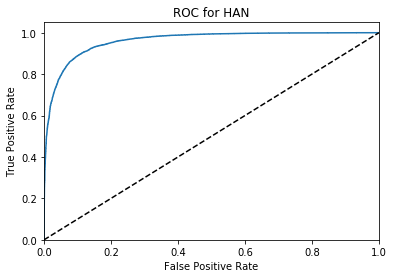

In [0]:
y_test = data_test['sentiment']
scores = model_han.predict(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores, pos_label=1)

print("AUC for HAN is {}".format(auc(fpr, tpr)))
plt.title('ROC for HAN')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

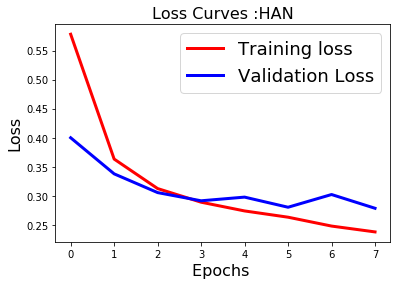

In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

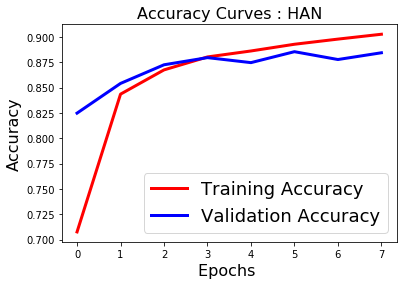

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

## Visualizing Hierarchical Attention Network Architecture

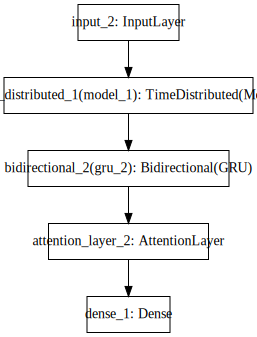

In [0]:
SVG(model_to_dot(model_han).create(prog='dot', format='svg'))

In [0]:
plot_model(model_han, to_file='model_han.png')

References<br>
https://en.wikipedia.org/wiki/Sentiment_analysis<br>
https://nlp.stanford.edu/projects/glove/<br>
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184<br>
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/<br>
https://www.kaggle.com/iarunava/google-text-classification-notebook <br>
https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py <br>
https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/ <br>
https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f <br>
https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e<br>